In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

In [2]:
def analyze_similarity_by_gene_family(csv_file_path, gene_family_column, comparing_column):
    """
    Analyze calculated_similarity distribution grouped by v_gene_light_family_x
    
    Parameters:
    csv_file_path (str): Path to the CSV file
    """
    
    # Load the CSV file
    print("Loading CSV file...")
    try:
        df = pd.read_csv(csv_file_path)
        print(f"Successfully loaded {len(df)} rows and {len(df.columns)} columns")
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return
    
    # Check if required columns exist
    required_columns = [gene_family_column, comparing_column]
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"Missing required columns: {missing_columns}")
        return
    
    # Clean the data - remove rows with missing values in key columns
    print("\nCleaning data...")
    initial_rows = len(df)
    df_clean = df.dropna(subset=[gene_family_column, comparing_column])
    
    # Remove rows where calculated_similarity is not numeric
    df_clean = df_clean[pd.to_numeric(df_clean[comparing_column], errors='coerce').notna()]
    df_clean[comparing_column] = pd.to_numeric(df_clean[comparing_column])
    
    print(f"Removed {initial_rows - len(df_clean)} rows with missing/invalid data")
    print(f"Final dataset: {len(df_clean)} rows")
    
    if len(df_clean) == 0:
        print("No valid data remaining after cleaning!")
        return
    
    # Group by v_gene_light_family_x and calculate statistics
    print("\nGrouping data and calculating statistics...")
    grouped_stats = df_clean.groupby(gene_family_column)[comparing_column].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: np.percentile(x, 25),  # Q1
        lambda x: np.percentile(x, 75)   # Q3
    ]).round(4)
    
    # Rename the lambda columns
    grouped_stats.columns = ['count', 'mean', 'median', 'std', 'min', 'max', 'q1', 'q3']
    
    # Sort by mean similarity (descending)
    grouped_stats = grouped_stats.sort_values('mean', ascending=False)
    
    print(f"\nFound {len(grouped_stats)} unique {gene_family_column} groups:")
    print(grouped_stats)
    
    # Create visualizations
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Calculated Similarity Analysis by V Gene Light Family', fontsize=16, fontweight='bold')
    
    # 1. Bar plot of mean values
    ax1 = axes[0, 0]
    mean_data = grouped_stats.sort_values('mean', ascending=True)
    bars = ax1.barh(range(len(mean_data)), mean_data['mean'], color='skyblue', alpha=0.7)
    ax1.set_yticks(range(len(mean_data)))
    ax1.set_yticklabels(mean_data.index, fontsize=10)
    ax1.set_xlabel('Mean Calculated Similarity')
    ax1.set_title('Mean Calculated Similarity by Gene Family')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, mean_data['mean'])):
        ax1.text(value + 0.001, i, f'{value:.3f}', va='center', fontsize=8)
    
    # 2. Box plot of distributions
    ax2 = axes[0, 1]
    # Prepare data for box plot
    box_data = []
    box_labels = []
    for family in grouped_stats.index:
        family_data = df_clean[df_clean[gene_family_column] == family][comparing_column]
        box_data.append(family_data)
        box_labels.append(f"{family}\n(n={len(family_data)})")
    
    bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)
    ax2.set_title('Distribution of Calculated Similarity by Gene Family')
    ax2.set_ylabel('Calculated Similarity')
    ax2.tick_params(axis='x', rotation=45, labelsize=9)
    
    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # 3. Histogram/density plot
    ax3 = axes[1, 0]
    # Plot overlapping histograms for top 5 most frequent families
    top_families = grouped_stats.nlargest(5, 'count').index
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i, family in enumerate(top_families):
        family_data = df_clean[df_clean[gene_family_column] == family][comparing_column]
        ax3.hist(family_data, bins=20, alpha=0.6, label=f'{family} (n={len(family_data)})', 
                color=colors[i], density=True)
    
    ax3.set_xlabel('Calculated Similarity')
    ax3.set_ylabel('Density')
    ax3.set_title('Distribution Comparison (Top 5 Families by Count)')
    ax3.legend(fontsize=9)
    ax3.grid(alpha=0.3)
    
    # 4. Sample size vs mean similarity scatter plot
    ax4 = axes[1, 1]
    scatter = ax4.scatter(grouped_stats['count'], grouped_stats['mean'], 
                         s=60, alpha=0.7, c=grouped_stats['std'], cmap='viridis')
    ax4.set_xlabel('Sample Size (Count)')
    ax4.set_ylabel('Mean Calculated Similarity')
    ax4.set_title('Mean Similarity vs Sample Size\n(Color = Standard Deviation)')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Standard Deviation')
    
    # Add family labels for points with large sample sizes
    large_samples = grouped_stats[grouped_stats['count'] >= grouped_stats['count'].quantile(0.7)]
    for family, row in large_samples.iterrows():
        ax4.annotate(family, (row['count'], row['mean']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Total families analyzed: {len(grouped_stats)}")
    print(f"Overall mean similarity: {df_clean[comparing_column].mean():.4f}")
    print(f"Overall std similarity: {df_clean[comparing_column].std():.4f}")
    print(f"Range: {df_clean[comparing_column].min():.4f} - {df_clean[comparing_column].max():.4f}")
    
    print(f"\nTop 5 families by mean similarity:")
    top_by_mean = grouped_stats.nlargest(5, 'mean')[['count', 'mean', 'std']]
    for family, row in top_by_mean.iterrows():
        print(f"  {family}: mean={row['mean']:.4f}, std={row['std']:.4f}, n={row['count']}")
    
    print(f"\nTop 5 families by sample size:")
    top_by_count = grouped_stats.nlargest(5, 'count')[['count', 'mean', 'std']]
    for family, row in top_by_count.iterrows():
        print(f"  {family}: n={row['count']}, mean={row['mean']:.4f}, std={row['std']:.4f}")
    
    # Statistical tests
    print(f"\n" + "="*60)
    print("STATISTICAL ANALYSIS")
    print("="*60)
    
    # ANOVA test to check if means differ significantly across groups
    groups = [df_clean[df_clean[gene_family_column] == family][comparing_column] 
              for family in grouped_stats.index if grouped_stats.loc[family, 'count'] >= 5]
    
    if len(groups) >= 2:
        f_stat, p_value = stats.f_oneway(*groups)
        print(f"One-way ANOVA test:")
        print(f"  F-statistic: {f_stat:.4f}")
        print(f"  p-value: {p_value:.2e}")
        if p_value < 0.05:
            print("  Result: Significant differences between groups (p < 0.05)")
        else:
            print("  Result: No significant differences between groups (p >= 0.05)")
    
    return df_clean, grouped_stats

In [3]:
gene_family_column = "v_gene_light_family_x"

comparing_column = "calculated_similarity"

In [4]:
csv_path = "/ibmm_data2/oas_database/paired_lea_tmp/paired_model/BERT2BERT/embedding_analysis/data/bert2gpt_df_merged_final_test_set_with_full_paired.csv"

Loading CSV file...
Successfully loaded 52138 rows and 47 columns

Cleaning data...
Removed 0 rows with missing/invalid data
Final dataset: 52138 rows

Grouping data and calculating statistics...

Found 21 unique v_gene_light_family_x groups:
                       count     mean   median      std      min       max  \
v_gene_light_family_x                                                        
IGKV4                   2839  67.7371  67.2566  14.5825  38.0531  100.0000   
IGKV1D                   467  67.3060  66.9725  14.9579  39.8148   99.0654   
IGKV1                  20418  66.5899  66.9725  14.6803  35.8491  100.0000   
IGKV3                   6574  66.5520  66.3636  14.6144  38.8889  100.0000   
IGKV3D                   132  65.7362  66.0550  12.2063  43.4426   91.6667   
IGKV2                   2650  60.6663  59.1304  14.5485  34.2105  100.0000   
IGKV6                    534  58.7024  62.2642   8.5155  39.8230   71.9626   
IGKV6D                   129  57.3677  61.8182  10.1354

/tmp/ipykernel_1383808/2637955770.py:88: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)


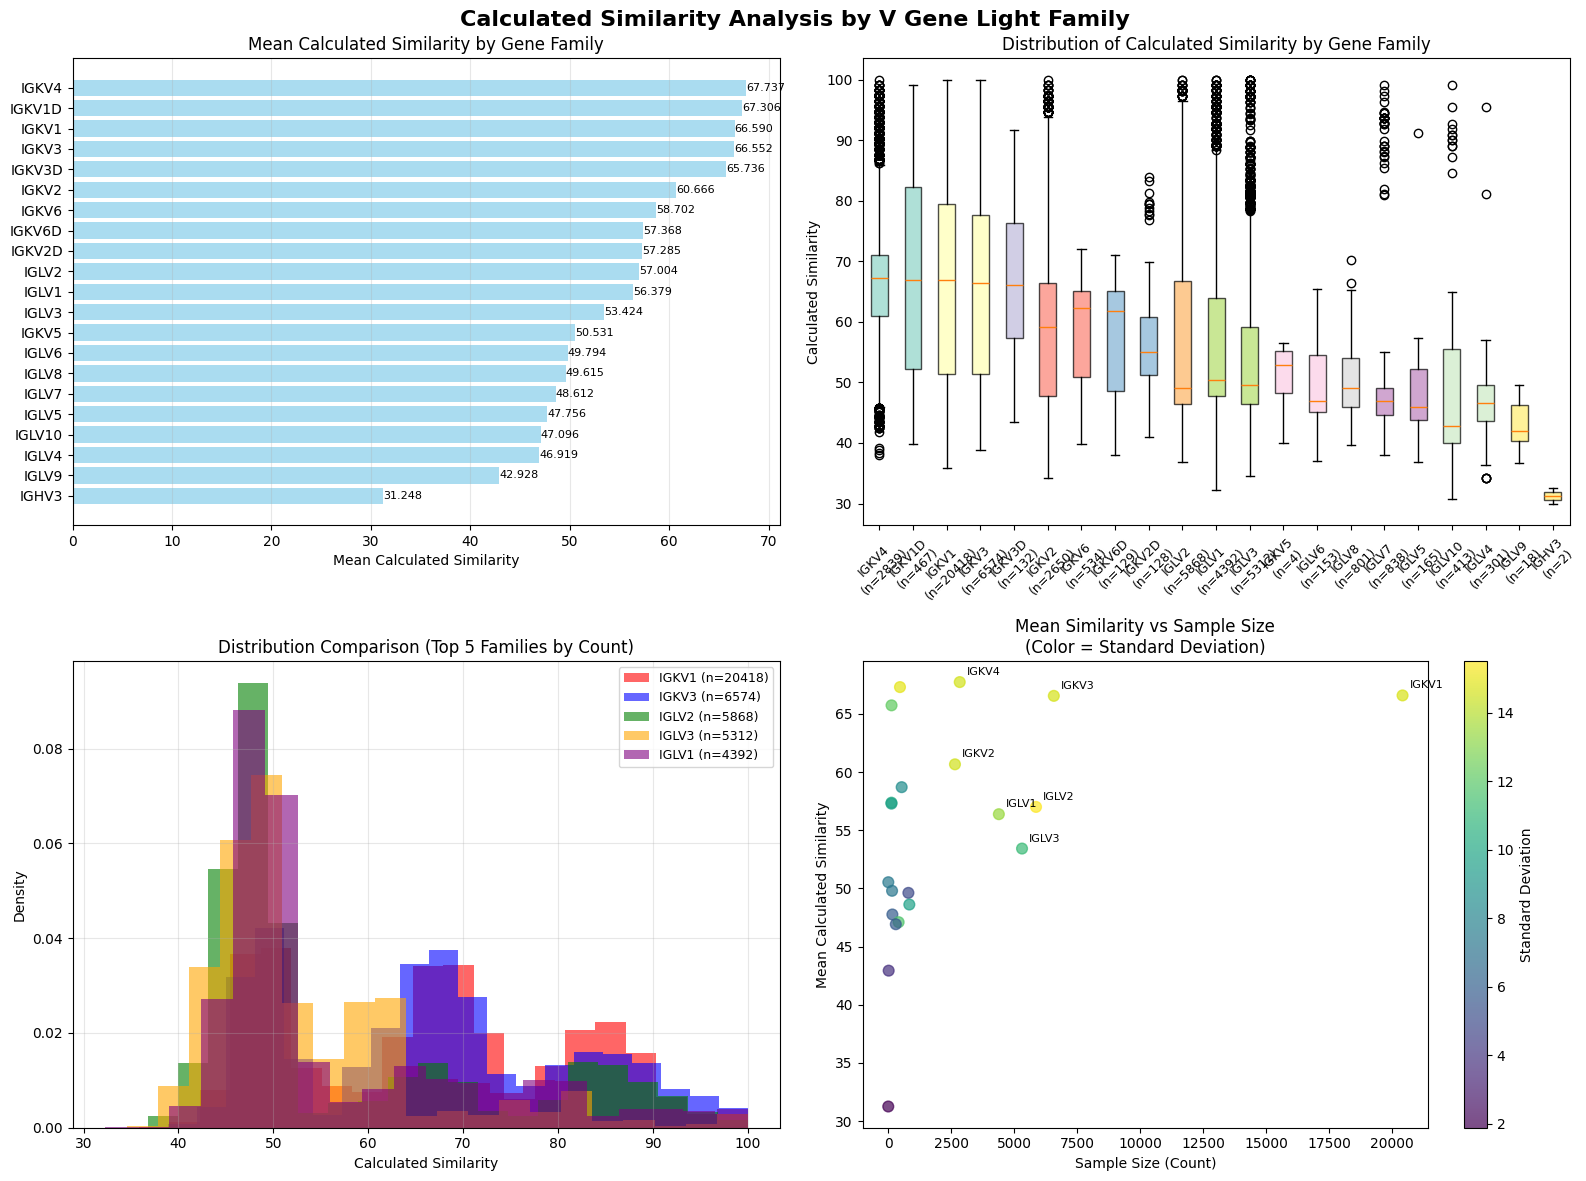


SUMMARY STATISTICS
Total families analyzed: 21
Overall mean similarity: 62.0065
Overall std similarity: 15.2074
Range: 29.9213 - 100.0000

Top 5 families by mean similarity:
  IGKV4: mean=67.7371, std=14.5825, n=2839.0
  IGKV1D: mean=67.3060, std=14.9579, n=467.0
  IGKV1: mean=66.5899, std=14.6803, n=20418.0
  IGKV3: mean=66.5520, std=14.6144, n=6574.0
  IGKV3D: mean=65.7362, std=12.2063, n=132.0

Top 5 families by sample size:
  IGKV1: n=20418.0, mean=66.5899, std=14.6803
  IGKV3: n=6574.0, mean=66.5520, std=14.6144
  IGLV2: n=5868.0, mean=57.0038, std=15.5143
  IGLV3: n=5312.0, mean=53.4243, std=11.1060
  IGLV1: n=4392.0, mean=56.3786, std=13.4301

STATISTICAL ANALYSIS
One-way ANOVA test:
  F-statistic: 529.2011
  p-value: 0.00e+00
  Result: Significant differences between groups (p < 0.05)


In [5]:
df_clean, grouped_stats = analyze_similarity_by_gene_family(csv_path, gene_family_column, comparing_column)

In [6]:
gene_family_column = "BType_x"

comparing_column = "calculated_similarity"

Loading CSV file...
Successfully loaded 52138 rows and 47 columns

Cleaning data...
Removed 0 rows with missing/invalid data
Final dataset: 52138 rows

Grouping data and calculating statistics...

Found 6 unique BType_x groups:
                  count     mean   median      std      min       max  \
BType_x                                                                 
Naive-B-Cells      8019  63.5464  60.3604  15.5929  39.2000  100.0000   
Unsorted-B-Cells  11237  62.2006  60.1852  15.1848  30.7018  100.0000   
Memory-B-Cells    26539  61.6033  60.1770  15.0901  29.9213  100.0000   
Plasma-B-Cells     6020  61.5442  61.4357  15.1641  30.7018   99.0909   
Plasmablast         263  59.1115  56.7568  14.1901  38.3929   95.3704   
RV+B-Cells           60  57.2952  52.4626  12.1568  42.4779   94.6429   

                       q1       q3  
BType_x                             
Naive-B-Cells     50.0000  72.5664  
Unsorted-B-Cells  48.6957  71.5596  
Memory-B-Cells    48.2143  70.3704  
Pl

/tmp/ipykernel_1383808/2637955770.py:88: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)


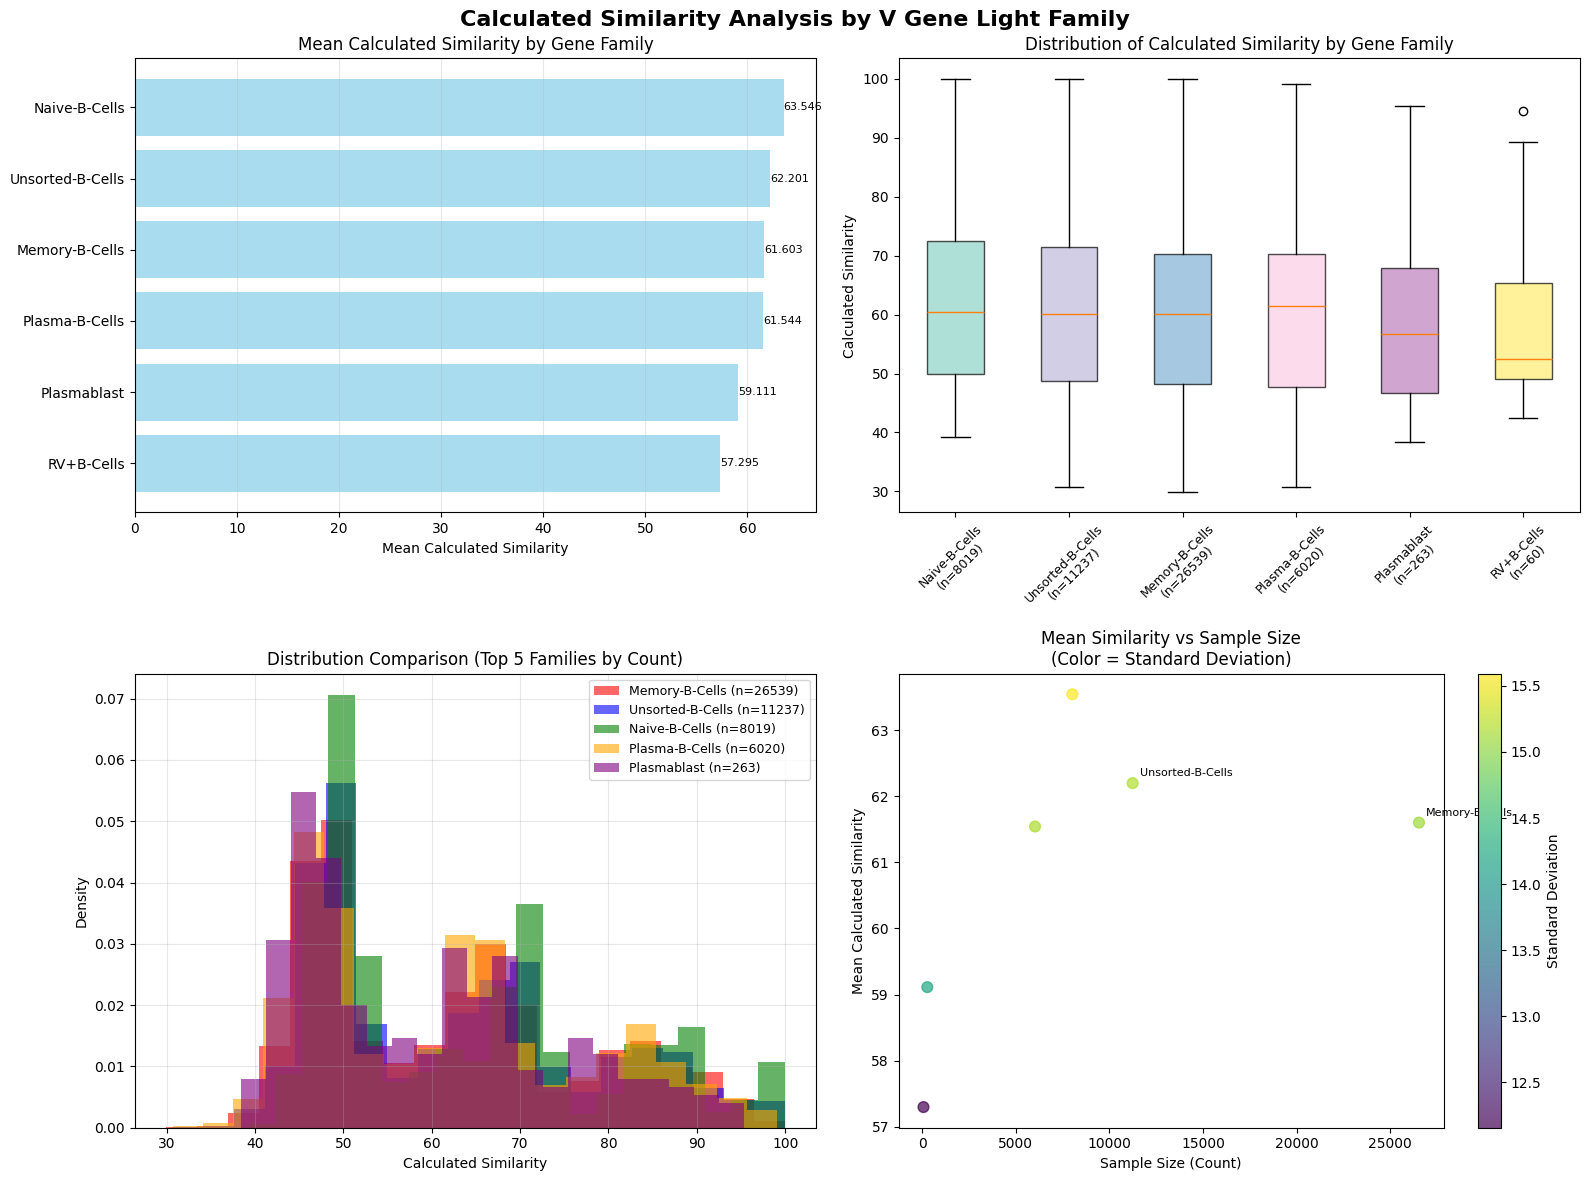


SUMMARY STATISTICS
Total families analyzed: 6
Overall mean similarity: 62.0065
Overall std similarity: 15.2074
Range: 29.9213 - 100.0000

Top 5 families by mean similarity:
  Naive-B-Cells: mean=63.5464, std=15.5929, n=8019.0
  Unsorted-B-Cells: mean=62.2006, std=15.1848, n=11237.0
  Memory-B-Cells: mean=61.6033, std=15.0901, n=26539.0
  Plasma-B-Cells: mean=61.5442, std=15.1641, n=6020.0
  Plasmablast: mean=59.1115, std=14.1901, n=263.0

Top 5 families by sample size:
  Memory-B-Cells: n=26539.0, mean=61.6033, std=15.0901
  Unsorted-B-Cells: n=11237.0, mean=62.2006, std=15.1848
  Naive-B-Cells: n=8019.0, mean=63.5464, std=15.5929
  Plasma-B-Cells: n=6020.0, mean=61.5442, std=15.1641
  Plasmablast: n=263.0, mean=59.1115, std=14.1901

STATISTICAL ANALYSIS
One-way ANOVA test:
  F-statistic: 24.7703
  p-value: 5.14e-25
  Result: Significant differences between groups (p < 0.05)


In [7]:
df_clean, grouped_stats = analyze_similarity_by_gene_family(csv_path, gene_family_column, comparing_column)